### Do simulations and replicate MEV algorithm

In [1]:
import numpy as np
import pickle
import os
import pandas as pds
import datetime
import textdistance
from sklearn import mixture
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
import time

### Algorithm

In [2]:
def levenshtein_similarity(a,b):

    """ Check that levenshtein similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if 1 - textdistance.levenshtein(a, b)/max(len(a),len(b)) >= 0.95:
        return 1
    else:
        return 0

def jaro_winkler_similarity(a,b):

    """ Check that jaro-winkler similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if textdistance.jaro_winkler(a,b) >= 0.99:
        return 1
    else:
        return 0

def strict_equality(a,b):

    """ Check that a and b values are equal.
        
        a: any value,
        b: any value """

    return a==b

def large_equality(a,b):

    """ Check that years a and b expressed with four numbers are within the same decade.
        
        a: year,
        b: year """

    return str(a)[:-1]==str(b)[:-1]

def comparison_vector(A_record, B, identifiers):
    
    """ Compare one record in A with all records in B. 
        Return the binary comparison of the identifiers for one record in A with all records in B.

        A_record:     series of one row, 
        B:            dataframe, 
        identifiers:  dict: k = column name, 
                            v = method in {'large','strict','levenshtein','jaro-winkler'}
    """

    methods = {'jaro-winkler':jaro_winkler_similarity, 'levenshtein':levenshtein_similarity, 'strict':strict_equality, 'large':large_equality}
    comparisons = {}
    for linking_var in identifiers:
        method = methods[identifiers[linking_var]]
        comparisons[linking_var] = np.array(B.apply(lambda row: method(A_record[linking_var], row[linking_var]), axis=1)).reshape(-1,1)
    return np.concatenate(tuple(comparisons.values()), axis = 1) 


def linking_score(A, B, identifiers, match, unmatch):
        
    """ Compare records in A with records in B, computing all linking scores for records in A with records in B. 
        Return the indices of records in A with the best match index for record in B.

        A:            dataframe, 
        B:            dataframe, 
        identifiers:  dict: k = column name, 
                            v = method in {'large','strict','levenshtein','jaro-winkler'}
        match:        array of probabilities of having same linking variables when being a match,
        unmatch:      array of probabilities of having same linking variables (at all, among the nA x nB pairs of record).
    """

    def compute_max_linking_score(A_record, B, identifiers, match, unmatch):
        similarities = comparison_vector(A_record, B, identifiers)
        if similarities.all(axis=1).sum() == 1: # there is one unique match: possible true match
            return B.iloc[similarities.all(axis=1),:].index[0], np.NaN
        else:
            linking_score = (np.multiply(similarities, np.log2(match/unmatch)) + np.multiply(1-similarities, np.log2((1-match)/(1-unmatch)))).sum(axis=1)
            return linking_score.argmax(), linking_score.max() # assign the first element of the argmax set A REVOIR

    links = A.apply(lambda row: compute_max_linking_score(row[list(identifiers.keys())], B, identifiers, match, unmatch), axis=1)
    idx_in_A = np.arange(A.shape[0])
    idx_in_B = np.array([element[0] for element in links])
    matching_scores = np.array([element[1] for element in links])
    max_score = np.nanmax(matching_scores)
    matching_scores = np.nan_to_num(matching_scores, nan=max_score+1) # possible true matches are given a higher score
    return {'A':idx_in_A, 'B':idx_in_B, 'scores':matching_scores}

def stratified_ATE(DF_group, pop_size):

    """ Compute the Average Treatment Effect on the specific stratum represented in DF_group.

        DF_group: dataframe,
        pop_size: size of the entire population from which the group comes from. 
    """

    n_treated, n_untreated = DF_group[DF_group.treatment == 1].shape[0], DF_group[DF_group.treatment == 0].shape[0]
    assert (n_treated!=0)&(n_untreated!=0), ("One group among treated/untreated is empty with this stratification.")
    avg_outcome_treated = (DF_group.treatment * DF_group.Y).sum() / n_treated 
    avg_outcome_untreated = ((1 - DF_group.treatment) * DF_group.Y).sum() / n_untreated
    var_treated = ( (DF_group.treatment * DF_group.Y - avg_outcome_treated)**2 ).sum() / (n_treated - 1)
    var_untreated = ( ((1 - DF_group.treatment) * DF_group.Y - avg_outcome_untreated)**2 ).sum() / (n_untreated - 1)
    size_group = DF_group.shape[0]
    ATE_group = (size_group/pop_size) * (avg_outcome_treated - avg_outcome_untreated)
    variance_group = (size_group/pop_size)**2 * (var_untreated/n_untreated + var_treated/n_treated)
    return ATE_group, variance_group

def logit(p):
    return np.log(p/(1-p))

def minmaxscaler(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

def propensity_score(DF, covariates, scaler, convert_to_logit):
    
    """ Compute propensity score estimates: the probability (logistic regression) that an observation is treated or not conditioned on some covariates.
        These estimates are built conditionaly on covariates passed using a logit after transformation by scaler (when one is specified).
        Estimated probabilities can be converted into logit (convert_to_logit parameter).

        DF:                dataframe,
        covariates:        list of strings for covariates variable in DF,
        scaler:            sklearn.preprocessing function scaler for exemple,
        convert_to_logit:  boolean for converting probabilities to logit when building the propensity score estimates based on a logistic regression
    """
    exog = covariates.copy()
    if scaler != None:
        DF[exog] = scaler(DF[exog])
    if 'intercept' not in DF.columns:
        DF['intercept'] = 1
    exog.append('intercept')
    model = sm.Logit(DF.treatment, DF[exog]).fit()
    predictions = model.predict(DF[exog])
    if convert_to_logit:
        return logit(predictions)
    else: 
        return predictions

def ATE(DF, strata):
    
    """ Compute the Average Treatment Effect in DF according to the stratification method:
        no stratification when strata is None, 
        stratified dataframe build based on the list of specific covariates when one is passed,
        or propensity score stratification.
        propensity score estimates and propensity score quantiles assignment should be already built for this last method.
        
        DF:                dataframe,
        strata:            value in {None, [...], 'propensity stratification'}
                           [...] variables to compute the strata on.
    """
    
    pop_size = DF.shape[0]
    if strata == None: # no stratification
        return stratified_ATE(DF, pop_size)
    elif strata == 'propensity stratification': # propensity score stratification
        assert ('propensity_score' in DF.columns)&('prop_score_quantile' in DF.columns), ("For propensity score stratification you need first to add the propensity_score and prop_score_quantile columns into the dataframe.")
        ATE, variance = 0, 0
        for q in DF['prop_score_quantile'].unique():
            stratum_data = DF[DF['prop_score_quantile'] == q]
            ATE_stratum, variance_stratum = stratified_ATE(stratum_data, pop_size)
            ATE += ATE_stratum
            variance += variance_stratum
        return ATE, variance
    else: # stratification based on the covariates passed
        ATE, variance = 0, 0
        for stratum in DF.groupby(strata):
            stratum_id, stratum_data = stratum
            ATE_stratum, variance_stratum = stratified_ATE(stratum_data, pop_size)
            ATE += ATE_stratum
            variance += variance_stratum
        return ATE, variance

def Minimum_Estimated_Variance(A, B, identifiers, match, unmatch):

    """ Compare records in A with records in B, computing all linking scores for records in A with records in B. 
        Return the indices of records in A with the best match index for record in B.

        A: dataframe, 
        B: dataframe, 
        identifiers: dict: k = column name, v = method in {'large','strict','levenshtein','jaro-winkler',
        match: array of probabilities of having same linking variables when being a match,
        unmatch: array of probabilities of having same linking variables (at all, among the nA x nB pairs of record)
    """

    ATE_list = []
    Var_list = []
    matchings = linking_score(A, B, identifiers, match, unmatch)
    for score in np.sort(np.unique(matchings['scores']))[::-1]:
        best_matches = matchings['scores'] >= score
        from_A = A.iloc[best_matches,:].reset_index(drop=True)
        from_B = B.iloc[matchings['B'][best_matches],:].reset_index(drop=True)
        linked_records = pds.concat([from_A, from_B.Y], axis=1)
        ATE_links, variance_links = ATE(linked_records, 'propensity stratification')
        ATE_list.append(ATE_links)
        Var_list.append(variance_links)
    return ATE_list, Var_list

### Generates association and launch algorithm, build confidence intervals

In [3]:
nbr_iter = 10 # ~ 3 minutes per iteration for the following

In [4]:
name_DF = 'DF_N=4401_2023-01-16.csv'
DF = pds.read_csv(os.path.join('..', '..', 'datasets', name_DF), delimiter = ',')
DF = DF[~DF.duplicated()] # delete duplicates
DF = DF.dropna() # delete NaN values
DF['was_born_female'] = DF['was_born_female'].astype('int32') # turn was_born_female into int type (once Nan values have been removed)

identifiers = {'family_name':'jaro-winkler','was_born_female':'strict','country':'strict','birth_year':'large'}
covariates = ['X1','X2','X3','X4','X5']

results = pds.DataFrame({"set":np.array([]), "iter":np.array([]), "variance":np.array([]), "ate":np.array([])})

for i in tqdm(range(nbr_iter)):

    ########## GENERATES ASSOCIATION ##########

    # generate treatment
    DF['treatment'] = np.random.binomial(n = 1, p = 0.4, size = DF.shape[0])

    # generate covariates
    DF['X1'] = 2020 - DF['birth_year'] # age
    DF['X2'] = np.random.normal(loc = 2.5, scale = 1, size = DF.shape[0])
    DF['X3'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
    DF['X4'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
    DF['X5'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])

    # generate outcome
    residual_errors = np.random.normal(size = DF.shape[0])
    a = 5.5
    b = 0.01
    c = 0.08
    d = 0.7

    #DF['Y'] = - 10 + a*DF['treatment'] + b*np.exp(DF['X4']) + c*DF['X3']*DF['X1'] + d*DF['X5'] ### FIXED TREATMENT EFFECT
    DF['Y'] = - 10 + a*DF['treatment']*DF['X2'] + b*np.exp(DF['X4']) + c*DF['X3']*DF['X1'] + d*DF['X5'] ### NOT FIXED TREATMENT EFFECT

    overlap = DF.sample(n = 800)

    A = pds.concat([DF.sample(n = 1400), overlap]).drop(['Y'], axis = 1)
    A = A.reset_index(drop=True)

    B = pds.concat([DF.sample(n = 2000), overlap])[list(identifiers.keys())+['Y']]
    B = B.reset_index(drop=True)

    ########## ETSR Algorithm ##########

    # Parameters
    # match:    probability of having same linking var when being true matches
    # unmatch:  probability of having same linking var (at all)

    match = np.repeat(0.95, len(identifiers.keys()))
    unmatch = A.apply(lambda row: comparison_vector(row, B, identifiers).sum(axis=0), axis=1).sum() / (A.shape[0]*B.shape[0]) # for each A record and for each linking variable, we check 'the probability' to match (over the nA * nB pairs)

    A['propensity_score'] = propensity_score(A, covariates, minmaxscaler, True)
    q = 5 # recommended: 5
    A['prop_score_quantile'] = pds.qcut(A['propensity_score'], q, labels = False)

    list_of_ATE, list_of_variance = Minimum_Estimated_Variance(A, B, identifiers, match, unmatch)

    length = len(list_of_ATE)
    new_results = pds.DataFrame({"set":np.arange(length), "iter":np.repeat(i, length), "variance":np.array(list_of_variance), "ate":np.array(list_of_ATE)})
    results = pds.concat([results, new_results])

  0%|          | 0/10 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.665349
         Iterations 4


 10%|█         | 1/10 [03:31<31:45, 211.68s/it]

Optimization terminated successfully.
         Current function value: 0.676818
         Iterations 4


 20%|██        | 2/10 [07:03<28:13, 211.65s/it]

Optimization terminated successfully.
         Current function value: 0.671038
         Iterations 4


 30%|███       | 3/10 [10:37<24:50, 212.96s/it]

Optimization terminated successfully.
         Current function value: 0.669104
         Iterations 4


 40%|████      | 4/10 [14:12<21:22, 213.81s/it]

Optimization terminated successfully.
         Current function value: 0.674173
         Iterations 4


 50%|█████     | 5/10 [17:49<17:53, 214.74s/it]

Optimization terminated successfully.
         Current function value: 0.668584
         Iterations 4


 60%|██████    | 6/10 [21:21<14:16, 214.02s/it]

Optimization terminated successfully.
         Current function value: 0.675028
         Iterations 4


 70%|███████   | 7/10 [24:54<10:40, 213.62s/it]

Optimization terminated successfully.
         Current function value: 0.670923
         Iterations 4


 80%|████████  | 8/10 [28:26<07:06, 213.11s/it]

Optimization terminated successfully.
         Current function value: 0.672679
         Iterations 4


 90%|█████████ | 9/10 [31:58<03:32, 212.65s/it]

Optimization terminated successfully.
         Current function value: 0.677578
         Iterations 4


100%|██████████| 10/10 [35:29<00:00, 212.98s/it]


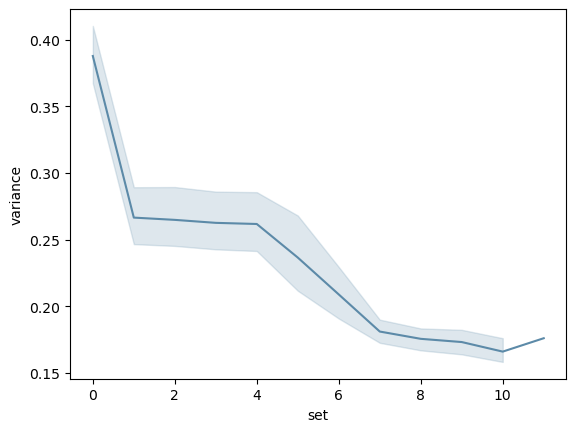

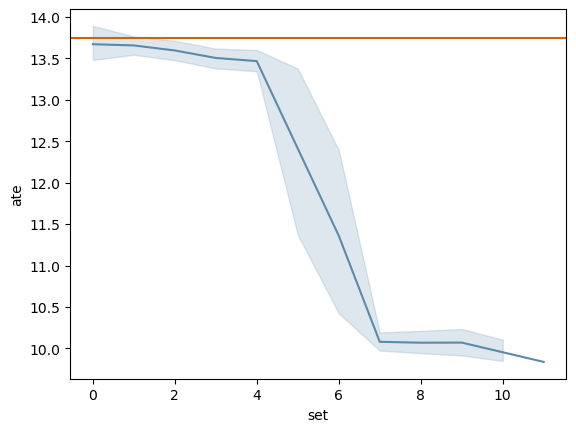

In [5]:
darkorange = (0.804, 0.4, 0)
airforceblue = (0.36, 0.54, 0.66)

sns.lineplot(data = results, x = "set", y = "variance", color = airforceblue);
plt.title("");
plt.show();

sns.lineplot(data = results, x = "set", y = "ate", color = airforceblue);
plt.axhline(y = 2.5 * a, color = darkorange); # fixed treatment effect = a, non-fixed treatment effect = E(X2) * a = 2.5 * a
plt.title("");
plt.show();